# Analyse et prédiction de la production d'un central photovoltaïque en tenant compte des variables climatiques et des productions des années précédentes

# Importation des bibliothèques

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Chargement des données et prétraitement des données

In [4]:
data = pd.read_excel('C:\\Users\\Francial\\Projet dans github\\Mon projet\\Données\\data.xlsx', index_col=0, parse_dates=True)

In [3]:
data.head()

,KW,IRRADIATION,PRECIPITATION,TEMPERATURE,WINDSPEED
datetime,,,,,
2020-01-01 02:00:00,0.0,0.0,0.00,1.61,8.99
2020-01-01 03:00:00,0.0,0.0,0.00,1.55,8.78
2020-01-01 04:00:00,0.0,0.0,0.00,1.53,8.99
2020-01-01 05:00:00,0.0,0.0,0.01,1.53,9.32
2020-01-01 06:00:00,0.0,0.0,0.02,1.30,9.37


In [4]:
data.describe()

,KW,IRRADIATION,PRECIPITATION,TEMPERATURE,WINDSPEED
count,17542.000000,17542.000000,17542.000000,17542.00000,17542.000000
mean,0.186649,86.817187,0.067635,10.59722,3.745011
std,0.290253,120.271742,0.247101,9.93962,2.001926
min,0.000000,0.000000,0.000000,-13.52000,0.060000
25%,0.000000,0.000000,0.000000,2.08000,2.340000
50%,0.000000,2.980000,0.000000,9.87000,3.310000
75%,0.317750,155.072500,0.030000,18.40000,4.850000
max,1.047000,418.620000,10.330000,36.25000,18.990000


# Vérification s'il y a des valeurs manquantes

In [5]:
missing_values = data.isnull().sum()
print(missing_values)

KW               0
IRRADIATION      0
PRECIPITATION    0
TEMPERATURE      0
WINDSPEED        0
dtype: int64


In [6]:
# used to check for missing or null values in a DataFrame

data.isnull()

,KW,IRRADIATION,PRECIPITATION,TEMPERATURE,WINDSPEED
datetime,,,,,
2020-01-01 02:00:00,False,False,False,False,False
2020-01-01 03:00:00,False,False,False,False,False
2020-01-01 04:00:00,False,False,False,False,False
2020-01-01 05:00:00,False,False,False,False,False
2020-01-01 06:00:00,False,False,False,False,False
...,...,...,...,...,...
2021-12-31 19:00:00,False,False,False,False,False
2021-12-31 20:00:00,False,False,False,False,False
2021-12-31 21:00:00,False,False,False,False,False


# Vérification la présence de valeurs aberrantes


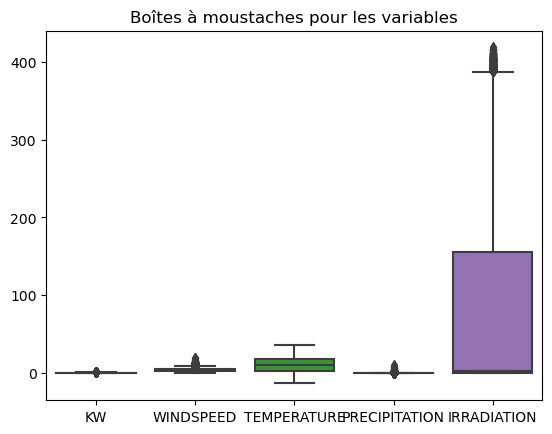

In [7]:
sns.boxplot(data=data[['KW', 'WINDSPEED', 'TEMPERATURE', 'PRECIPITATION', 'IRRADIATION']])
plt.title('Boîtes à moustaches pour les variables')
plt.show()

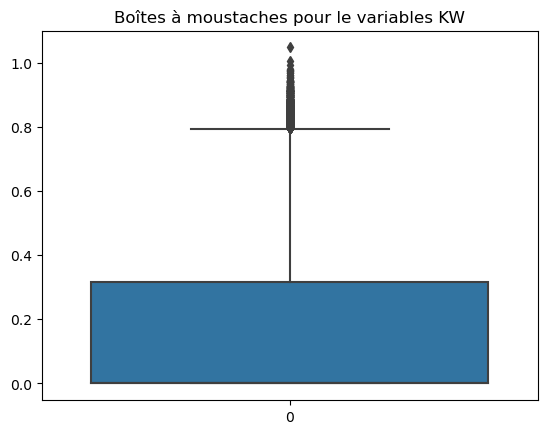

In [8]:
sns.boxplot(data=data['KW'])
plt.title('Boîtes à moustaches pour le variables KW')
plt.show()

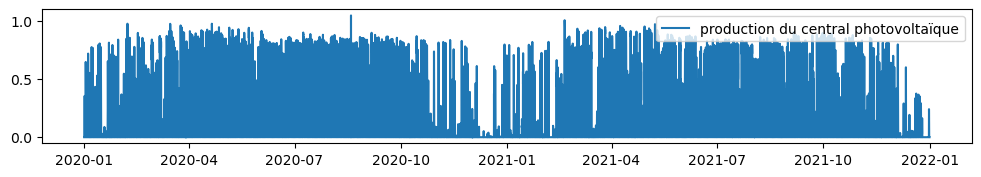

In [9]:
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(data['KW'], label='production du central photovoltaïque')
plt.legend()

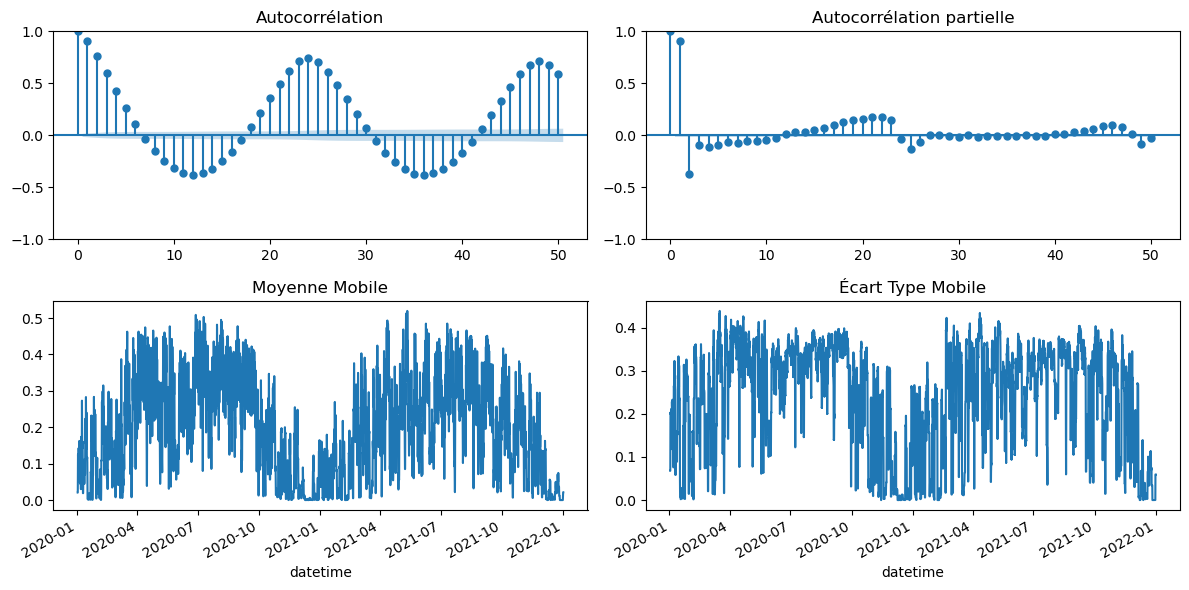

In [13]:
rolling_window = 30
plt.figure(figsize=(12, 6))
# Plot de l'autocorrélation
plt.subplot(2, 2, 1)
plot_acf(data['KW'], lags=50, ax=plt.gca(), title='Autocorrélation')

# Plot de l'autocorrélation partielle
plt.subplot(2, 2, 2)
plot_pacf(data['KW'], lags=50, ax=plt.gca(), title='Autocorrélation partielle')

# Plot de la moyenne mobile
plt.subplot(2, 2, 3)
data['KW'].rolling(rolling_window).mean().plot(ax=plt.gca())
plt.title('Moyenne Mobile')

# Plot de l'écart type mobile
plt.subplot(2, 2, 4)
data['KW'].rolling(rolling_window).std().plot(ax=plt.gca())
plt.title('Écart Type Mobile')

plt.tight_layout()
plt.show()


In [11]:
threshold = 1.5  # Facteur pour définir la limite des valeurs aberrantes (peut être ajusté)
for column in ['KW']:
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr
    data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# Afficher les données après la gestion des valeurs aberrantes

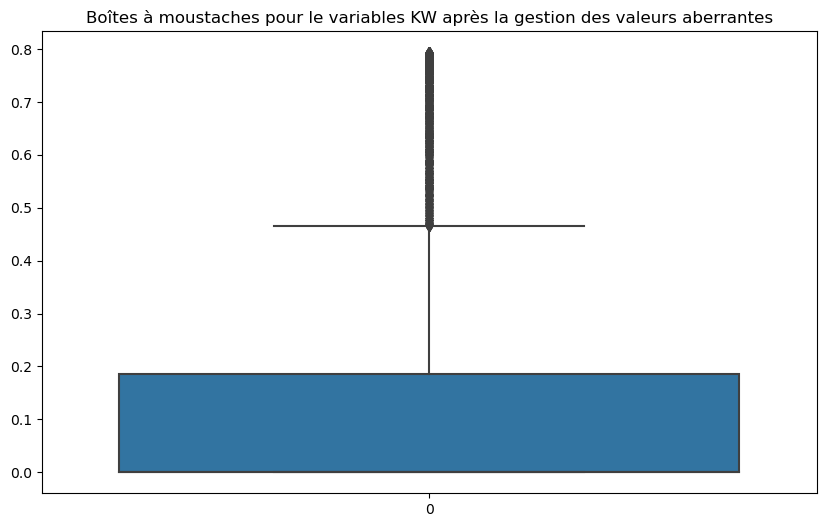

In [12]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data['KW'])
plt.title('Boîtes à moustaches pour le variables KW après la gestion des valeurs aberrantes')
plt.show()

In [13]:
data.describe()

,KW,IRRADIATION,PRECIPITATION,TEMPERATURE,WINDSPEED
count,16396.000000,16396.000000,16396.000000,16396.000000,16396.000000
mean,0.140731,72.664172,0.070647,9.945959,3.721669
std,0.240320,109.377393,0.252716,9.712853,1.998795
min,0.000000,0.000000,0.000000,-13.520000,0.060000
25%,0.000000,0.000000,0.000000,1.660000,2.330000
50%,0.000000,0.000000,0.000000,8.940000,3.280000
75%,0.186000,125.330000,0.030000,17.650000,4.800000
max,0.794000,415.170000,10.330000,36.250000,18.990000


# Analyse des corrélations entre les variables climatiques et la production d'électricité

In [14]:
variables_climatiques = ['IRRADIATION', 'TEMPERATURE', 'WINDSPEED', 'PRECIPITATION']
variables = ['KW'] + variables_climatiques
data_selected = data[variables]

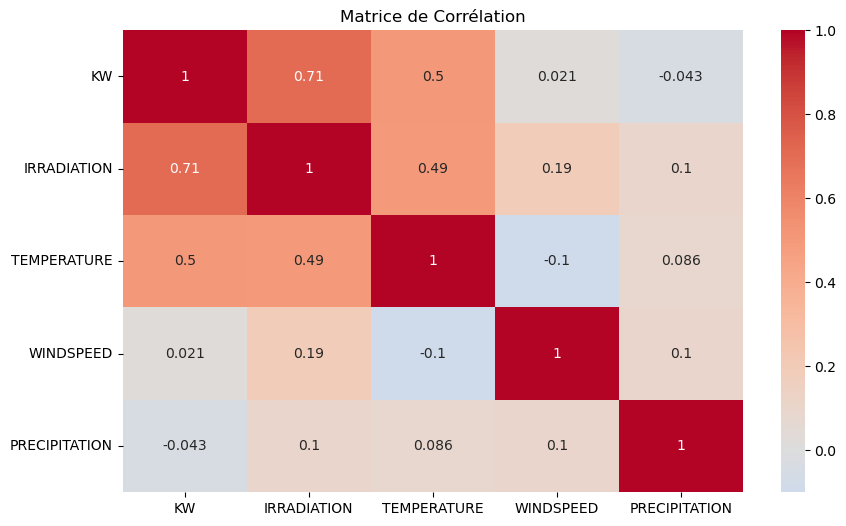

In [15]:
correlation_matrix = data_selected.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matrice de Corrélation')
plt.show()


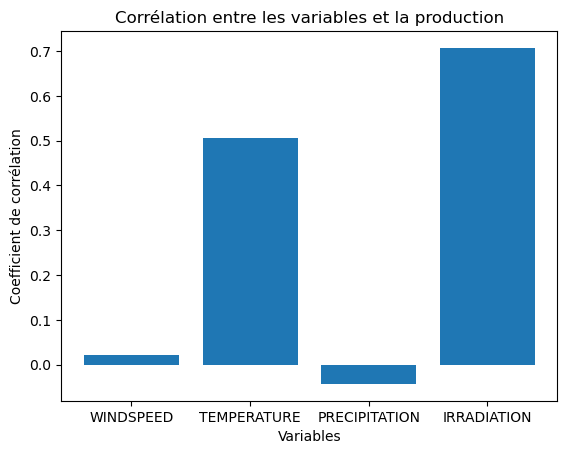

In [16]:
correlation_with_production = data[['WINDSPEED', 'TEMPERATURE', 'PRECIPITATION', 'IRRADIATION', 'KW']].corr()
# Visualiser les coefficients de corrélation
plt.bar(correlation_with_production.columns[:-1], correlation_with_production.iloc[-1, :-1])
plt.xlabel('Variables')
plt.ylabel('Coefficient de corrélation')
plt.title('Corrélation entre les variables et la production')
plt.show()


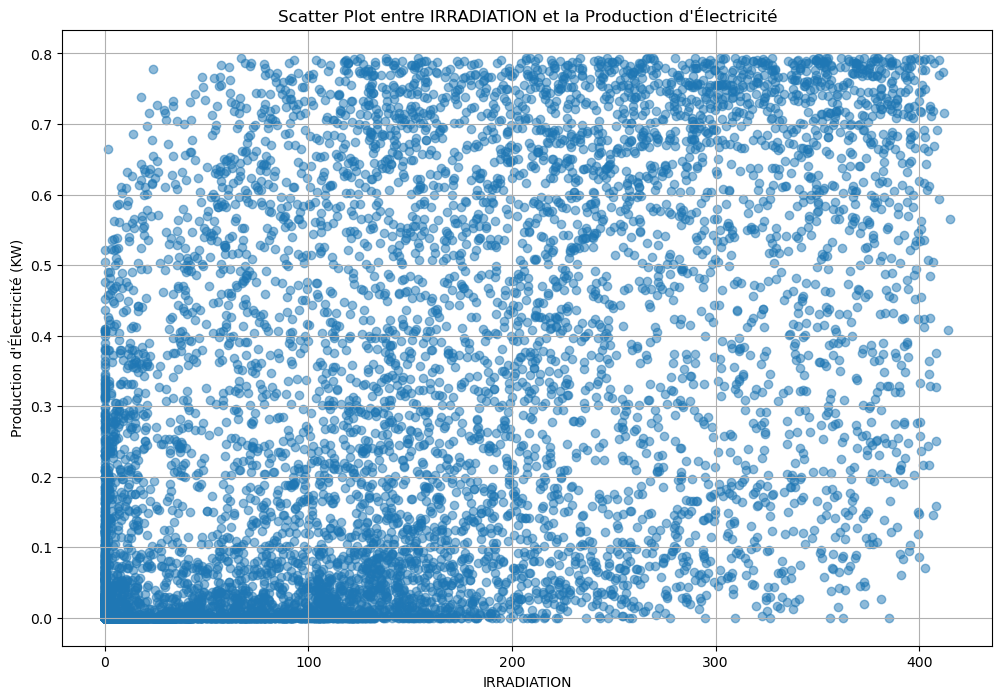

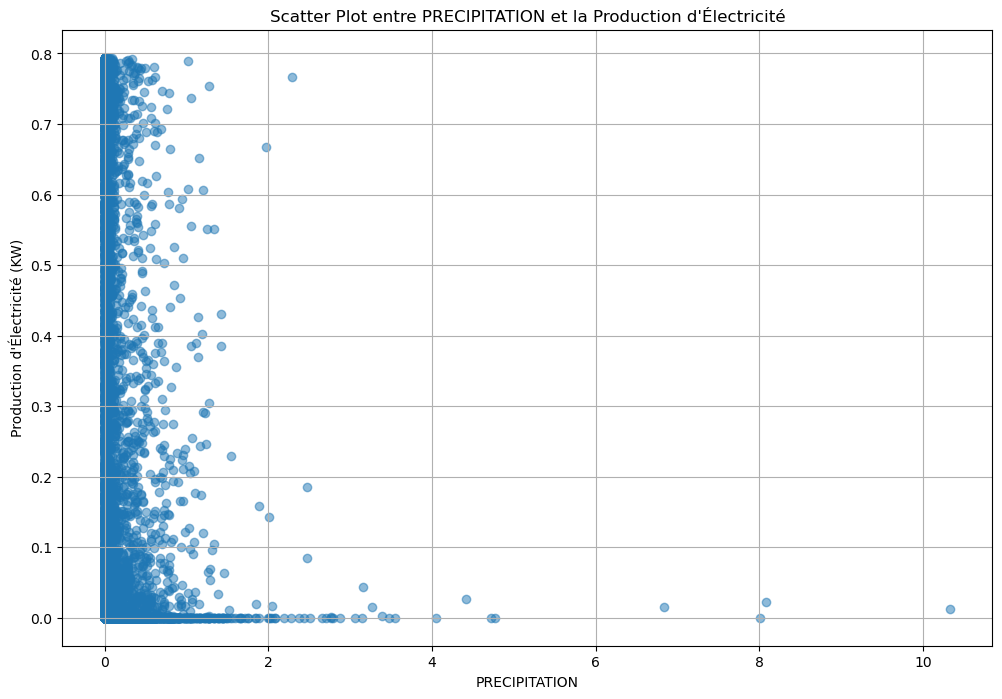

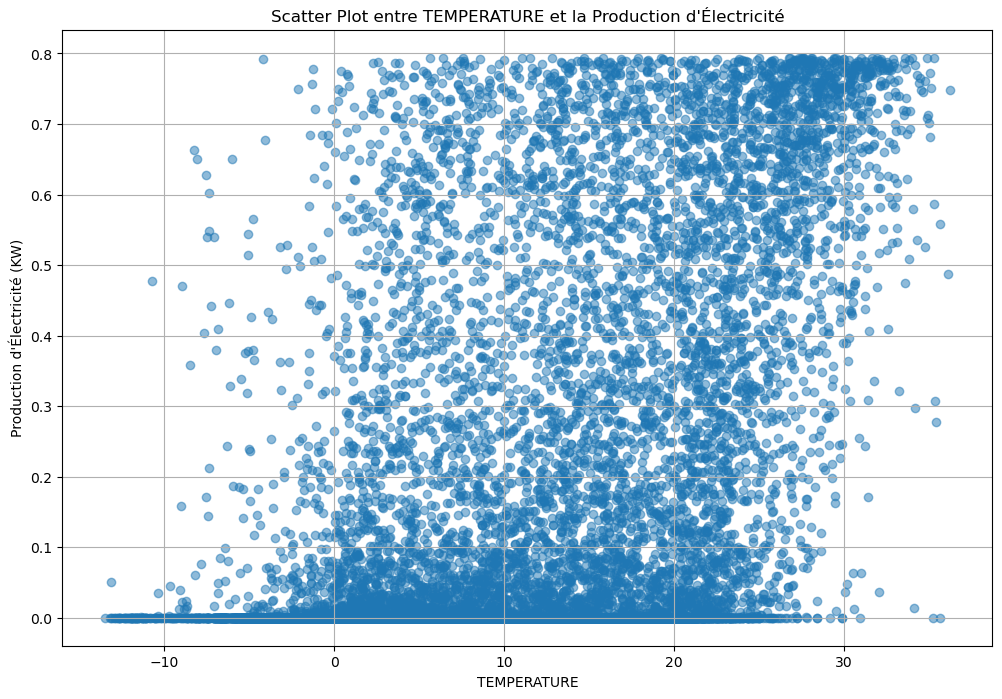

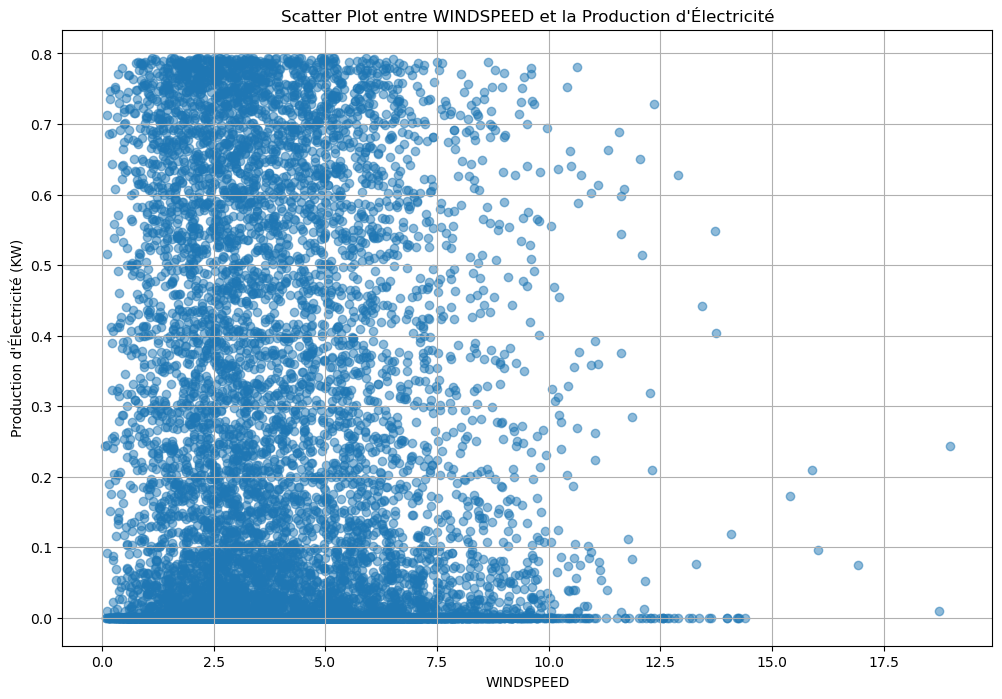

In [17]:
# Variables climatiques à analyser
climate_variables = ['IRRADIATION', 'PRECIPITATION', 'TEMPERATURE', 'WINDSPEED']

# Créer des scatter plots pour chaque variable climatique
for var in climate_variables:

    plt.figure(figsize=(12, 8))
    plt.scatter(data[var], data['KW'], alpha=0.5)
    plt.title(f"Scatter Plot entre {var} et la Production d'Électricité")
    plt.xlabel(var)
    plt.ylabel('Production d\'Électricité (KW)')
    plt.grid(True)
    plt.show()


# Identification des modèles saisonniers et les tendances annuelles dans les données.

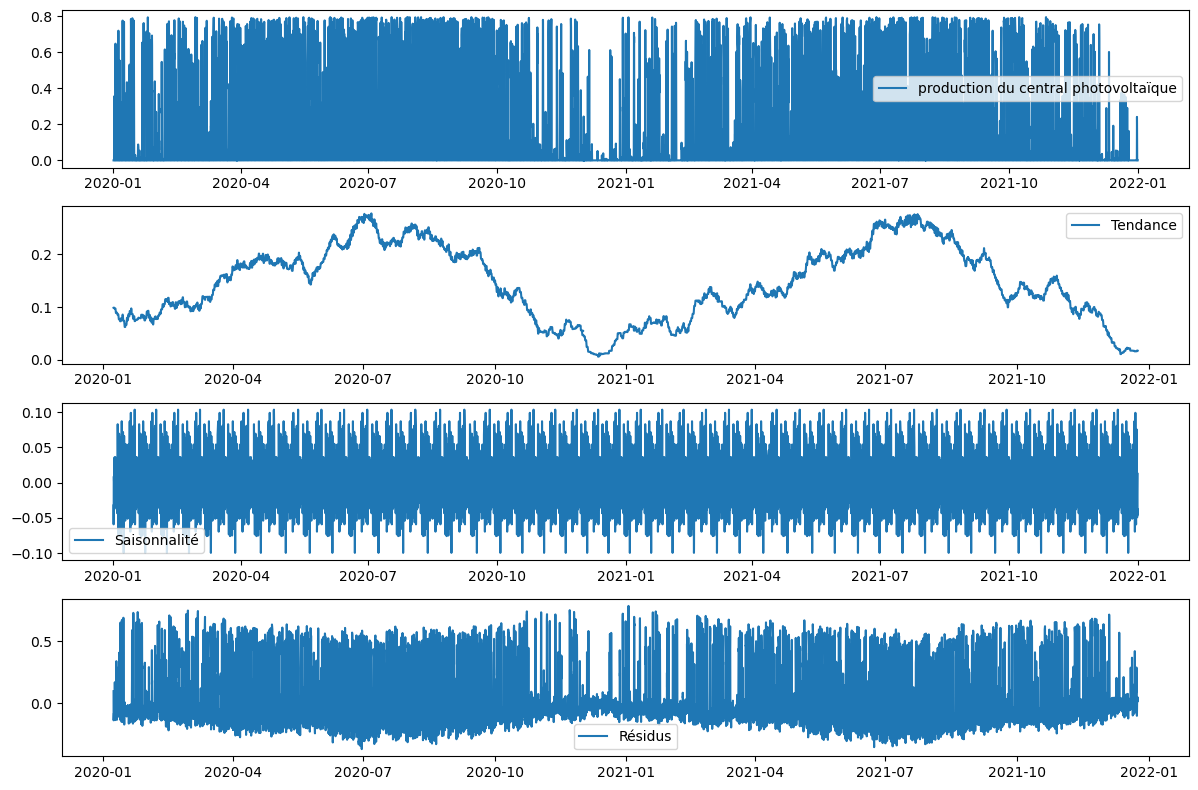

In [18]:
# Décomposition saisonnière additive
decomposition = seasonal_decompose(data['KW'], model='additive', period=365)

# Afficher les composantes de la décomposition
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(data['KW'], label='production du central photovoltaïque')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(trend, label='Tendance')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(seasonal,label='Saisonnalité')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(residual, label='Résidus')
plt.legend()

plt.tight_layout()
plt.show()
